In [146]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

In [147]:
def read_spe(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
        bins = np.array(list(map(lambda x: float(x.strip()), lines[12:-16])))

    for i in range(len(lines) - 1, -1, -1):
        if lines[i].startswith("$ENER_FIT"):
            bin_width = float(lines[i+1].strip().split(" ")[-1])
            break

    return bins, bin_width
bins, bin_width = read_spe("data/calibration.Spe")

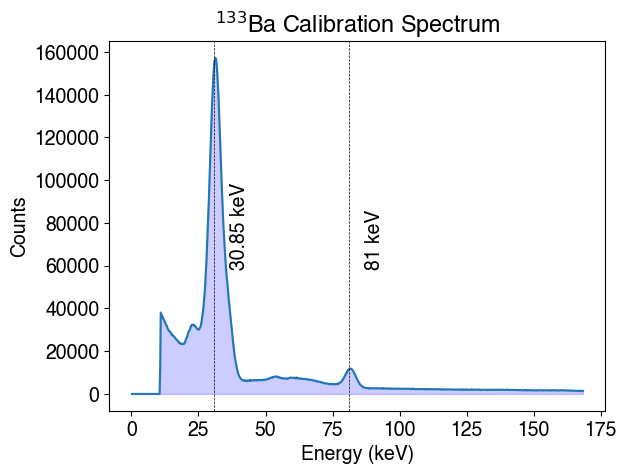

In [163]:
y = bins[:800]
x = np.arange(y.size) * bin_width + bin_width

# Fill underneath the curve
plt.fill_between(x, y, color="blue", alpha=0.2)

plt.plot(x, y)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")

plt.axvline(x=30.85, color="black", linestyle="--", linewidth=0.5)
plt.axvline(x=81, color="black", linestyle="--", linewidth=0.5)

plt.annotate("30.85 keV", (30.85 + 6, 60000), color="black", rotation=90)
plt.annotate("81 keV", (81 + 6, 60000), color="black", rotation=90)

plt.title("$^{133}$Ba Calibration Spectrum")
plt.rcParams.update({'font.size': 14, 'font.family': 'Helvetica'})

plt.savefig("calibration.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

In [149]:
bins[100:150]

array([ 28873.,  29368.,  29953.,  30445.,  31564.,  31820.,  32334.,
        32320.,  32444.,  32397.,  32305.,  31698.,  31791.,  31426.,
        31056.,  30608.,  30268.,  30232.,  30076.,  30336.,  30856.,
        31279.,  32020.,  33220.,  35142.,  37175.,  38970.,  41700.,
        45099.,  47800.,  52674.,  57109.,  62454.,  68854.,  75101.,
        81927.,  89280.,  96859., 104419., 112996., 121142., 128979.,
       136167., 142265., 147773., 151730., 155370., 156324., 157206.,
       156432.])

In [150]:
peak = bins[148]

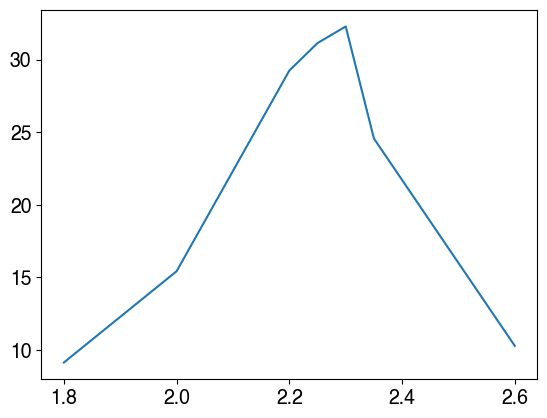

In [151]:
m = 9.1094e-28 # g
c = 3.0e10 # cm/s
d = 0.18 # cm
e = 4.803e-10 # ?
rho = 20.3 # cm
l = 10.0 # cm
I = np.array([ # Amperes
    2.32,
    3.03,
    3.69,
    4.61,
    5.34
])
B = np.array([ # Gauss
    50.0,
    70.0,
    80.0,
    100.1,
    119.9
])
V = [ # Volts
    np.array([1.00, 1.12, 1.275, 1.38, 1.46]), # Data maybe not great here, because zoom on MAESTRO wasn't showing all counts
    np.array([1.8, 2.0, 2.2, 2.25, 2.3, 2.35, 2.6]),
    np.array([1.5, 2.50, 2.90, 2.95, 3.05, 3.50]),
    np.array([3.50, 3.70, 3.80, 4.20, 4.46, 4.55, 4.70, 4.90]),
    np.array([3.5, 5.1, 5.3, 5.4, 5.5, 6.2])
]
V_statvolts = V * 300
total_counts = [
    np.array([15.0, 24.0, 35.0, 34.0, 18.0]),
    np.array([32, 54, 117, 109, 113, 86, 36]),
    np.array([18, 65, 67, 88, 44, 26]),
    np.array([80.0, 131.0, 136.0, 120.0, 117.0, 118.0, 126.0,  70.0]),
    np.array([54, 264, 166, 133, 104, 35])
]
minutes = [
    np.array([2.75, 2.5, 3.0, 2.75, 3.0]),
    np.array([3.5, 3.5, 4.0, 3.5, 3.5, 3.5, 3.5]),
    np.array([2.5, 2.5, 1.5, 2.0, 1.5, 2.5]),
    np.array([1.5, 1.5, 1.5, 1.5, 3.5, 3.75, 4.25, 3.5]),
    np.array([2.0, 2.5, 2.5, 2.5, 2.5, 2.0])
]

counts_per_minute = []
for i in range(len(I)):
    counts_per_minute.append(total_counts[i] / minutes[i])

# peak_E = np.array([
#     [],
#.     187.69 ish
#     [271.04, 274.16, 274.99, 273.53, 0, 0, 271.87, 274.99]
# ])
i = 1
plt.plot(V[i], counts_per_minute[i])
plt.show()

In [152]:
# Expected maximum voltage (tells expected velocity of the electron)

def relativistic_expected_voltage(B):
    B_p = B / 10000.
    V = B_p*d/np.sqrt(1/c**2+(m/(e*B_p*rho))**2)
    return V / 1000.

def classical_expected_voltage(B):
    B_p = B / 10000.
    V = B_p*d
    return V / 1000.

3.266945635788386


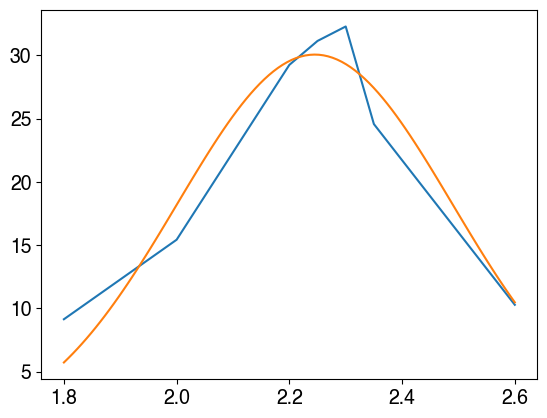

params:  [30.06409608  2.24512521  0.24441687]
...... 0.09238089158030367


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

In [167]:
def gaussian(x, a, mu, sigma):
    return a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def fit_to_n_versus_b(i, func=gaussian):
    plt.plot(V[i], counts_per_minute[i])

    popt, pcov = curve_fit(f=func, xdata=V[i], ydata=counts_per_minute[i], p0=[32, 2.3, 0.01])
    # popt, pcov = curve_fit(f=func, xdata=V[i], ydata=counts_per_minute[i], p0=[-0.1, 0, 30])
    sigma = np.sqrt(np.diag(pcov))
    x = np.linspace(V[i][0], V[i][-1], 100)
    y = func(x, *popt)
    plt.plot(x, y)

    predicted = func(V[i], *popt)
    chi2 = np.sum((counts_per_minute[i] - predicted)**2/sigma[0]) / V[i].size
    print(chi2)

    plt.show()

    print("params: ", popt)

    return popt, pcov

i = 1
popt, pcov = fit_to_n_versus_b(i, gaussian)
sigma_V = popt[2]
# Use first uncert for fit, second for velocity
uncert_V = sigma_V / np.sqrt(V[i].size) # V[i][np.argmax(counts_per_minute[i])]
print("......", uncert_V)

# plt.plot(B, V[:, np.argmax(counts_per_minute, axis=0)])
# plt.show()

In [154]:
# Calculate the expected velocity range of detector
i = 0
voltage = V_statvolts[i][np.argmax(counts_per_minute[i])]
u_0 = voltage / d / (B[i]*3e-6)
qa = 2*m*d/(e*l**2)
qb = B[i]*3e-6
qc = -voltage / d

print(qa, qb, qc)

# Solve quadratic
v_0 = (-qb + np.sqrt(qb**2 - 4*qa*qc)) / (2*qa)
v_1 = (-qb - np.sqrt(qb**2 - 4*qa*qc)) / (2*qa)

print("v_0: ", v_0)
print("v_1: ", v_1)
print("Expected velocities: ", u_0)

6.827782635852591e-21 0.00015000000000000001 -7.666666666666666
v_0:  51111.40656943227
v_1:  -2.196906492199987e+16
Expected velocities:  51111.1111111111


In [155]:
def gamma(v):
    return 1.0/np.sqrt(1.0 - np.square(v)/np.square(c))

def ke_vs(B, V):
    E = V / d
    v = E / B
    return m*np.square(c)*(gamma(v) - 1.0)

def G2Tesla(B):
    return B / 10000.0

def J2keV(a):
    return a / 1.6e-16

# print(J2keV(ke_vs(G2Tesla(100.0), 4130.)))

def ke_cyc(B):
    p = B*e*rho
    return m*np.square(c)*(np.sqrt(1.0 + np.square(p/(m*c))) - 1.0)

print(J2keV(ke_cyc(G2Tesla(70.))))

1.2796988000963526e+16


[0.10196078 0.05681818 0.02542373 0.06578947 0.17647059] [0.13778971 0.08241027 0.04781681 0.08368604 0.19141176]


/var/folders/n_/c3r8w0s95xl271j98y2lzhz80000gn/T/ipykernel_64872/118114094.py:32: RuntimeWarning: divide by zero encountered in divide
  return 1./np.sqrt((c**2/(e_m*rho))**2/np.square((B)) + 1.)


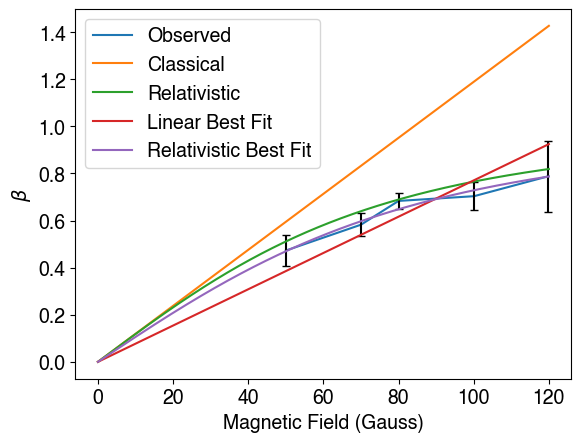

In [156]:
observed_V_0 = np.array([V[i][total_counts[i].argmax()] for i in range(len(B))]) * 0.003336 * 1000 # Conversion to statavolts
relative_uncert_obs_V_0 = np.array([
    (V[i][total_counts[i].argmax() + 1] - V[i][total_counts[i].argmax() - 1]) / 2.0 / V[i][total_counts[i].argmax()]
    for i in range(len(B))
])
E_obs = observed_V_0 / d
rho = 20.3
Bs = np.array([92.3, 86.6, 88.2, 97.8, 93.8])
relative_uncert_B = np.std(Bs) / np.sqrt(Bs.size) / B
relative_uncert_beta = relative_uncert_obs_V_0 + relative_uncert_B
print(relative_uncert_obs_V_0, relative_uncert_beta)
x = np.linspace(0, 120, 1000)

# Observed
def obs_beta(B):
    return E_obs / B
plt.plot(B, obs_beta(B))
plt.errorbar(B, obs_beta(B), yerr=relative_uncert_beta * obs_beta(B), fmt='none', color="black", capsize=3)

# Classical Prediction
def classical_beta(B, em):
    # return em * rho / c**2 * B
    # return 0.011 * B
    return em * rho / c**2 * B
plt.plot(x, classical_beta(x, e/m))

# Relativistic Prediction
def relativistic_beta(B, e_m):
    return 1./np.sqrt(np.square((c**2)/(e_m * rho * B)) + 1.)

def relativistic_beta(B, e_m):
    return 1./np.sqrt((c**2/(e_m*rho))**2/np.square((B)) + 1.)

plt.plot(x, relativistic_beta(x, e/m))

# Classical Best Fit
def line(x, m):
    return m*x
sigma_obs = obs_beta(B)
popt_classical, pcov_classical = curve_fit(f=line, xdata=B, ydata=obs_beta(B), sigma=sigma_obs, p0=[1], absolute_sigma=True)
sigma_fit_classical = np.sqrt(np.diag(pcov_classical))
plt.plot(x, line(x, *popt_classical))

# Relativistic Best Fit
popt_rel, pcov_rel = curve_fit(f=relativistic_beta, xdata=B, ydata=obs_beta(B), sigma=sigma_obs, p0=[e/m], absolute_sigma=True)
sigma_fit_rel = np.sqrt(np.diag(pcov_rel))
plt.plot(x, relativistic_beta(x, *popt_rel))

plt.legend(["Observed", "Classical" , "Relativistic", "Linear Best Fit", "Relativistic Best Fit"])

plt.xlabel("Magnetic Field (Gauss)")
plt.ylabel("$\\beta$")
plt.show()

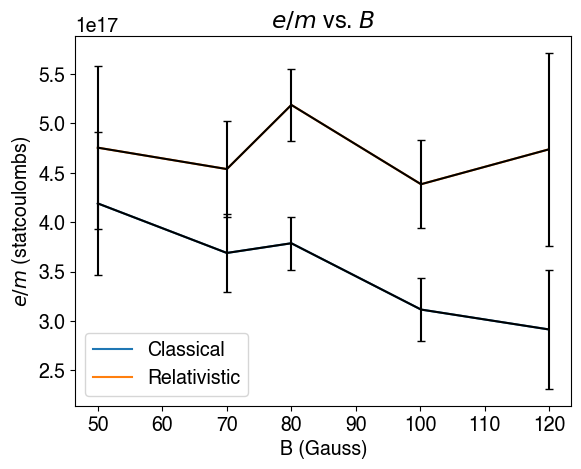

In [157]:
def e_m_from_B_classical(B, E):
    return 1./(np.square(B) * rho / (E * c**2))

relative_uncert_e_m_classical = 2 * relative_uncert_B + relative_uncert_obs_V_0

def e_m_from_B_rel(B ,E):
    return E/np.square(B) * 1./np.sqrt(1. - np.square(E/B)) * c**2 / rho

relative_uncert_e_m_relativistic = 2 * relative_uncert_B + relative_uncert_obs_V_0 # TODO: Not right, take into account gamma

y_cls = e_m_from_B_classical(B, E_obs)
plt.plot(B, y_cls)
plt.errorbar(B, y_cls, yerr=relative_uncert_e_m_classical * y_cls, capsize=3, color="black")

y_rel = e_m_from_B_rel(B, E_obs)
plt.plot(B, y_rel)
plt.errorbar(B, y_rel, yerr=relative_uncert_e_m_relativistic * y_rel, capsize=3, color="black")
plt.legend(["Classical", "Relativistic"])
plt.title("$e/m$ vs. $B$")
plt.xlabel("B (Gauss)")
plt.ylabel("$e/m$ (statcoulombs)")
plt.show()

In [158]:
m = 9.11e-28 # kg # eV, g
c = 3.0e10 # m/s
d = 0.18 # m
e = 1.6e-19
def gamma(v):
    return 1.0/np.sqrt(1.0 - np.square(v)/np.square(c))

def ke(B, V):
    E = V / d
    v = E*c / B 
    return m*np.square(c)*(gamma(v) - 1.0)

def G2Tesla(B):
    return B / 10000.0

def J2keV(a):
    return a / 1.6e-16

J2keV(ke(80, 3500. / 300)) / 1e7

361.7696372309184

In [159]:
Bs = [92.3, 86.6, 88.2, 97.8, 93.8]
np.std(Bs) / np.sqrt(np.mean(Bs))

0.41822446963088844